In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb

# Load data
data = pd.read_excel('EPOC dataset.xlsx')
validate_data = pd.read_excel('Validate dataset.xlsx')

# Data preprocessing
columns = ['metal', 'support', 'wt.%', 'solid electrolyte', 'ionic species', 'ionic species charge', 
           'particle size(nm)', 'metal loading (mg)', 'catalyst redox', 'CO2:H2 ratio', 'temp(℃)', 
           'rCO(mol/s)', 'voltage(V)', 'current(mA)', 'ρCO', 'ΛCO']

data.columns = columns

# Convert categorical data to numerical
data['metal'] = data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                      [55.8, 58.9, 58.7, 63.5, 65.4, 101.1, 102.9, 106.4, 195.1])
data['support'] = data['support'].fillna(0).replace(['Co3O4','ZnO','YSZ','α-Al2O3','CNF'], [1, 2, 3, 4, 5]).astype(int)
data['wt.%'] = data['wt.%'].fillna(100).astype(float)
data['ionic species'] = data['ionic species'].replace(['O2-','H+','Li+','Na+','K+'], [-2, 1, 2, 3, 4]).astype(int)
data['gas ratio'] = data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))
data = data.drop('CO2:H2 ratio', axis=1)
data.columns = ['M', 'S', 'WT.%', 'SE', 'IS', 'ISC', 'PS', 'ML', 'CR', 'T', 'RR', 'V', 'C', 'ρ', 'Λ', 'GR']

# Validation data preprocessing
validate_data.columns = columns
validate_data['metal'] = validate_data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                                        [55.8, 58.9, 58.7, 63.5, 65.4, 101.1, 102.9, 106.4, 195.1])
validate_data['support'] = validate_data['support'].fillna(0).replace(['Co3O4','ZnO','YSZ','α-Al2O3','CNF'], [1, 2, 3, 4, 5]).astype(int)
validate_data['wt.%'] = validate_data['wt.%'].fillna(100).astype(float)
validate_data['ionic species'] = validate_data['ionic species'].replace(['O2-','H+','Li+','Na+','K+'], [-2, 1, 2, 3, 4]).astype(int)
validate_data['gas ratio'] = validate_data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))
validate_data = validate_data.drop('CO2:H2 ratio', axis=1)
validate_data.columns = ['M', 'S', 'WT.%', 'SE', 'IS', 'ISC', 'PS', 'ML', 'CR', 'T', 'RR', 'V', 'C', 'ρ', 'Λ', 'GR']

# Additional feature engineering
def ionic_dir(row):
    return 1 if row['IS'] * row['V'] < 0 else 0

def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

validate_data['MD'] = validate_data.apply(ionic_dir, axis=1)
validate_data['BH'] = validate_data.apply(electro_class, axis=1)

# Feature and target selection
features = ['M', 'S', 'IS', 'T', 'V', 'GR', 'MD']
X_v = validate_data[features]
y_v = validate_data['BH']

# Feature scaling
scaler = StandardScaler()
X_v_scaled = scaler.fit_transform(X_v)

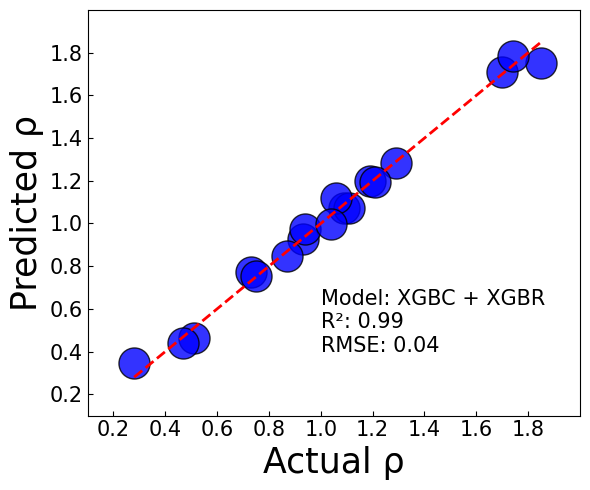

In [8]:
# XGBC + XGBR
XGBC = xgb.XGBClassifier(n_estimators=20, eta=0.2, max_depth=4, colsample_bytree=1, subsample=1, random_state=0)
XGBC.fit(X_v_scaled, y_v)
y_pred_class = XGBC.predict(X_v_scaled)

# Add classification results as a new feature
validate_data['BH'] = y_pred_class

# Prepare data for regression
features_reg = ['M', 'S', 'IS', 'T', 'V', 'GR', 'MD', 'BH']
X_v_reg = validate_data[features_reg]
y_v_reg = validate_data['ρ']
# Feature scaling
X_v_reg_scaled = scaler.fit_transform(X_v_reg)

XGBR = xgb.XGBRegressor(n_estimators=30, max_depth=5, eta=0.3, subsample=0.5, colsample_bytree=0.5, random_state=0)
XGBR.fit(X_v_reg_scaled, y_v_reg)
y_reg_pred = XGBR.predict(X_v_reg_scaled)

# plot the scatters with XGBR
mse = mean_squared_error(y_v_reg, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_v_reg, y_reg_pred)
    
fig = plt.figure(figsize=(6,5))
plt.scatter(y_v_reg, y_reg_pred, alpha=0.8, color='blue', edgecolors='k', s=500)
plt.plot([y_v_reg.min(),y_v_reg.max()], [y_v_reg.min(), y_v_reg.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(1, 0.4, f'Model: XGBC + XGBR\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', fontsize=15)
plt.tick_params(direction='in', which='both', labelsize=15)

plt.xlim(0.1, 2)
plt.ylim(0.1, 2)
plt.xticks(np.arange(0.2, 2, 0.2))
plt.yticks(np.arange(0.2, 2, 0.2))

plt.tight_layout()
plt.savefig('Validate Scatter (XGBC + XGBR).jpg', format='jpeg', dpi=600)
plt.show()

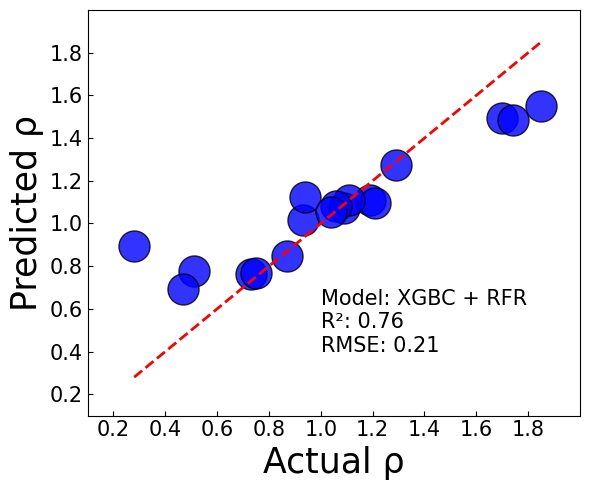

In [8]:
# XGBC + RFR
XGBC = xgb.XGBClassifier(n_estimators=20, eta=0.2, max_depth=4, colsample_bytree=1, subsample=1, random_state=0)
XGBC.fit(X_v_scaled, y_v)
y_pred_class = XGBC.predict(X_v_scaled)

# Add classification results as a new feature
validate_data['BH'] = y_pred_class

# Prepare data for regression
features_reg = ['M', 'S', 'IS', 'T', 'V', 'GR', 'MD', 'BH']
X_v_reg = validate_data[features_reg]
y_v_reg = validate_data['ρ']
# Feature scaling
X_v_reg_scaled = scaler.fit_transform(X_v_reg)

# plot the scatters with RFR
RFR = RandomForestRegressor(n_estimators=5, max_depth=8, min_samples_split=2, random_state=0)
RFR.fit(X_v_reg_scaled, y_v_reg)
y_reg_pred = RFR.predict(X_v_reg_scaled)

# plot the scatters with RFR
mse = mean_squared_error(y_v_reg, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_v_reg, y_reg_pred)
    
fig = plt.figure(figsize=(6,5))
plt.scatter(y_v_reg, y_reg_pred, alpha=0.8, color='blue', edgecolors='k', s=500)
plt.plot([y_v_reg.min(),y_v_reg.max()], [y_v_reg.min(), y_v_reg.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(1, 0.4, f'Model: XGBC + RFR\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', fontsize=15)
plt.tick_params(direction='in', which='both', labelsize=15)

plt.xlim(0.1, 2)
plt.ylim(0.1, 2)
plt.xticks(np.arange(0.2, 2, 0.2))
plt.yticks(np.arange(0.2, 2, 0.2))

plt.tight_layout()
plt.savefig('Validate Scatter (XGBC + RFR).jpg', format='jpeg', dpi=600)
plt.show()

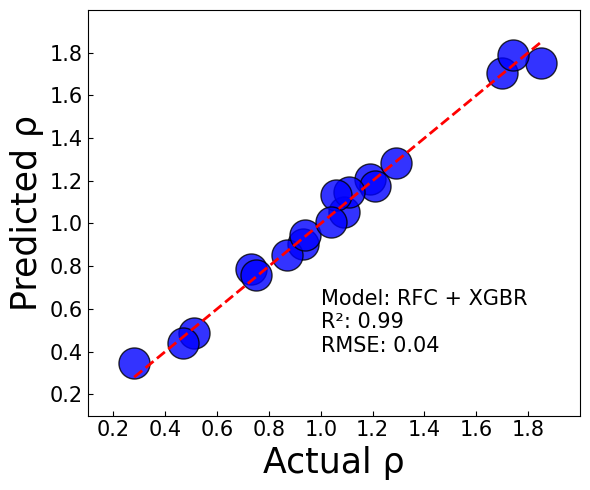

In [10]:
# RFC + XGBR
RFC = RandomForestClassifier(n_estimators=10, max_depth=6, min_samples_split=2, random_state=0)
RFC.fit(X_v_scaled, y_v)
y_pred_class = RFC.predict(X_v_scaled)

# Add classification results as a new feature
validate_data['BH'] = y_pred_class

# Prepare data for regression
features_reg = ['M', 'S', 'IS', 'T', 'V', 'GR', 'MD', 'BH']
X_v_reg = validate_data[features_reg]
y_v_reg = validate_data['ρ']
# Feature scaling
X_v_reg_scaled = scaler.fit_transform(X_v_reg)

XGBR = xgb.XGBRegressor(n_estimators=30, max_depth=5, eta=0.3, subsample=0.5, colsample_bytree=0.5, random_state=0)
XGBR.fit(X_v_reg_scaled, y_v_reg)
y_reg_pred = XGBR.predict(X_v_reg_scaled)

# plot the scatters with XGBR
mse = mean_squared_error(y_v_reg, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_v_reg, y_reg_pred)
    
fig = plt.figure(figsize=(6,5))
plt.scatter(y_v_reg, y_reg_pred, alpha=0.8, color='blue', edgecolors='k', s=500)
plt.plot([y_v_reg.min(),y_v_reg.max()], [y_v_reg.min(), y_v_reg.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(1, 0.4, f'Model: RFC + XGBR\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', fontsize=15)
plt.tick_params(direction='in', which='both', labelsize=15)

plt.xlim(0.1, 2)
plt.ylim(0.1, 2)
plt.xticks(np.arange(0.2, 2, 0.2))
plt.yticks(np.arange(0.2, 2, 0.2))

plt.tight_layout()
plt.savefig('Validate Scatter (RFC + XGBR).jpg', format='jpeg', dpi=600)
plt.show()

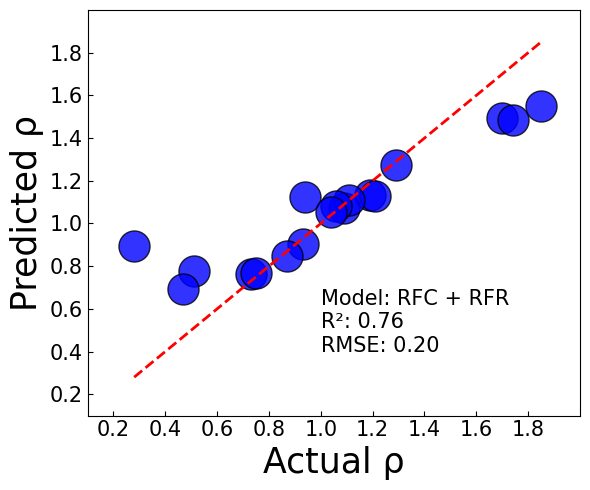

In [13]:
# RFC + RFR
RFC = RandomForestClassifier(n_estimators=10, max_depth=6, min_samples_split=2, random_state=0)
RFC.fit(X_v_scaled, y_v)
y_pred_class = RFC.predict(X_v_scaled)

# Add classification results as a new feature
validate_data['BH'] = y_pred_class

# Prepare data for regression
features_reg = ['M', 'S', 'IS', 'T', 'V', 'GR', 'MD', 'BH']
X_v_reg = validate_data[features_reg]
y_v_reg = validate_data['ρ']
# Feature scaling
X_v_reg_scaled = scaler.fit_transform(X_v_reg)

RFR = RandomForestRegressor(n_estimators=5, max_depth=8, min_samples_split=2, random_state=0)
RFR.fit(X_v_reg_scaled, y_v_reg)
y_reg_pred = RFR.predict(X_v_reg_scaled)

# plot the scatters with RFR
mse = mean_squared_error(y_v_reg, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_v_reg, y_reg_pred)
    
fig = plt.figure(figsize=(6,5))
plt.scatter(y_v_reg, y_reg_pred, alpha=0.8, color='blue', edgecolors='k', s=500)
plt.plot([y_v_reg.min(),y_v_reg.max()], [y_v_reg.min(), y_v_reg.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(1, 0.4, f'Model: RFC + RFR\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', fontsize=15)
plt.tick_params(direction='in', which='both', labelsize=15)

plt.xlim(0.1, 2)
plt.ylim(0.1, 2)
plt.xticks(np.arange(0.2, 2, 0.2))
plt.yticks(np.arange(0.2, 2, 0.2))

plt.tight_layout()
plt.savefig('Validate Scatter (RFC + RFR).jpg', format='jpeg', dpi=600)
plt.show()

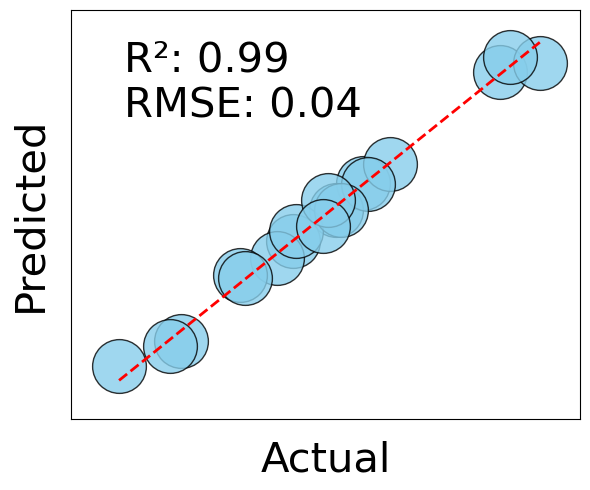

In [26]:
# XGBC + XGBR
XGBC = xgb.XGBClassifier(n_estimators=20, eta=0.2, max_depth=4, colsample_bytree=1, subsample=1, random_state=0)
XGBC.fit(X_v_scaled, y_v)
y_pred_class = XGBC.predict(X_v_scaled)

# Add classification results as a new feature
validate_data['BH'] = y_pred_class

# Prepare data for regression
features_reg = ['M', 'S', 'IS', 'T', 'V', 'GR', 'MD', 'BH']
X_v_reg = validate_data[features_reg]
y_v_reg = validate_data['ρ']
# Feature scaling
X_v_reg_scaled = scaler.fit_transform(X_v_reg)

XGBR = xgb.XGBRegressor(n_estimators=30, max_depth=5, eta=0.3, subsample=0.5, colsample_bytree=0.5, random_state=0)
XGBR.fit(X_v_reg_scaled, y_v_reg)
y_reg_pred = XGBR.predict(X_v_reg_scaled)

# plot the scatters with XGBR
mse = mean_squared_error(y_v_reg, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_v_reg, y_reg_pred)
    
fig = plt.figure(figsize=(6,5))
plt.scatter(y_v_reg, y_reg_pred, alpha=0.8, color='skyblue', edgecolors='k', s=1500)
plt.plot([y_v_reg.min(),y_v_reg.max()], [y_v_reg.min(), y_v_reg.max()], 'r--', lw=2)
plt.xlabel('Actual', size=30, labelpad=15)
plt.ylabel('Predicted', size=30, labelpad=15)
plt.text(0.3, 1.5, f'R²: {r2:.2f}\nRMSE: {rmse:.2f}', fontsize=30)
plt.tick_params(direction='in', which='both', length=0, labelbottom=False, labelleft=False)

plt.xlim(0.1, 2)
plt.ylim(0.1, 2)
plt.xticks(np.arange(0.2, 2, 0.2))
plt.yticks(np.arange(0.2, 2, 0.2))

plt.tight_layout()
plt.savefig('Validate Scatter for GA.jpg', format='jpeg', dpi=600)
plt.show()